In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, log_loss
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Activation, Dropout
from keras.datasets import cifar10, mnist
from keras.utils import to_categorical

# Functions

In [ ]:
def compute_measure(true_label, predicted_label, train_losses, test_losses):

  t_idx = (true_label == predicted_label)
  f_idx = np.logical_not(t_idx)
  p_idx = (true_label > 0)
  n_idx = np.logical_not(p_idx)
  tp = np.sum(np.logical_and(t_idx, p_idx))

  tn = np.sum(np.logical_and(t_idx, n_idx))

  fp = np.sum(n_idx) - tn
  fn = np.sum(p_idx) - tp
  tp_fp_tn_fn_list = []

  with np.errstate(divide = 'ignore'):
    sen = (1.0 * tp) / (tp + fn)
  with np.errstate(divide = 'ignore'):
    spec = (1.0 * tn) / (tn + fp)
  with np.errstate(divide = 'ignore'):
    f1 = tp / (tp + 0.5 * (fp + fn))

  acc = (tp + tn) * 1.0 / (tp + fp + tn + fn)

  d = np.log2(1 + acc) + np.log2(1 + (sen + spec) / 2)
  f1_micro = f1_score(true_label, predicted_label, average = 'micro')
  f1_macro = f1_score(true_label, predicted_label, average = 'macro')

  eta_train = 1 - (np.std(train_losses) / (np.mean(train_losses) + (1e-10))) ** 2
  eta_test = 1 - (np.std(test_losses) / (np.mean(test_losses) + (1e-10))) ** 2
  eta_ratio = eta_test / eta_train


  ans = []
  ans.append(acc)
  ans.append(sen)
  ans.append(spec)
  ans.append(f1_micro)
  ans.append(f1_macro)
  ans.append(d)
  ans.append(eta_train)
  ans.append(eta_test)
  ans.append(eta_ratio)

  return ans

In [ ]:
def model_metrics(true, pred, train_losses, test_losses):

  ans = compute_measure(true, pred, train_losses, test_losses)
  print("Accuracy is {0:4f}".format(ans[0]))
  print("Sensitivity is {0:4f}".format(ans[1]))
  print("Specificity is {0:4f}".format(ans[2]))
  print("F1-Score Micro is {0:4f}".format(ans[3]))
  print("F1-Score Macro is {0:4f}".format(ans[4]))
  print("Diagnostic Index is {0:4f}".format(ans[5]))
  print("Eta Train is {0:4f}".format(ans[6]))
  print("Eta Test is {0:4f}".format(ans[7]))
  print("Eta Ratio is {0:4f}".format(ans[8]))

In [ ]:
def doPcaTsne(train_data, test_data, explained_variance, perplexity):
  pca = PCA(n_components = train_data.shape[1])
  data_pca = pca.fit_transform(train_data)
  exp_var = np.cumsum(pca.explained_variance_ratio_)
  n_comp = np.argmax(exp_var >= explained_variance) + 1
  train_pca = data_pca[:, :n_comp]
  test_pca = pca.transform(test_data)[:, :n_comp]

  tsne = TSNE(n_components = 2, perplexity = perplexity, init = 'pca', random_state = 0)
  train_tsne = tsne.fit_transform(train_pca)
  test_tsne = tsne.fit_transform(test_pca)
  return train_tsne, test_tsne

In [ ]:
def getLosses(history):
  train_losses = history.history['loss']
  val_losses = history.history['val_loss']
  return train_losses, val_losses

In [ ]:
def plotLosses(train_losses, val_losses):
  fig = plt.figure(figsize = (7, 3))
  plt.plot(train_losses, label = 'Training Loss')
  plt.plot(val_losses, 'b-', label = 'Test Loss')
  plt.title('Training and Test Loss Curves')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid('on')
  plt.show()

# Load Data, Reshape, Normalize

In [ ]:
# Load the MINIST dataset
(x_train_minist, y_train_minist), (x_test_minist, y_test_minist) = mnist.load_data()
# Print summary of MINIST data
print("Training data shape:", x_train_minist.shape)  # (60000, 28, 28)
print("Training labels shape:", y_train_minist.shape)  # (60000,)
print("Testing data shape:", x_test_minist.shape)  # (10000, 28, 28)
print("Testing labels shape:", y_test_minist.shape)  # (10000,)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing data shape: (10000, 28, 28)
Testing labels shape: (10000,)


In [ ]:
# Load CIFAR-10 dataset
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
# Print summary of CIFAR-10 data
print("Training data shape:", x_train_cifar.shape)  # (50000, 32, 32, 3)
print("Training labels shape:", y_train_cifar.shape)  # (50000, 1)
print("Testing data shape:", x_test_cifar.shape)  # (10000, 32, 32, 3)
print("Testing labels shape:", y_test_cifar.shape)  # (10000, 1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


In [ ]:
# MINIST
## Reshape for PCA and normalize
x_train_minist = x_train_minist.astype('float32') / 255
x_train_minist = x_train_minist.reshape(60000, 28 * 28)
x_test_minist = x_test_minist.astype('float32') / 255
x_test_minist = x_test_minist.reshape(10000, 28 * 28)
## One-hot encoding
y_train_minist = to_categorical(y_train_minist, 10)
y_test_minist = to_categorical(y_test_minist, 10)
y_test_minist_labels = np.argmax(y_test_minist, axis = 1)

# CIFAR
## Reshape for PCA and normalize
x_train_cifar = x_train_cifar.astype('float32') / 255
x_train_cifar = x_train_cifar.reshape(50000, 32 * 32 * 3)
x_test_cifar = x_test_cifar.astype('float32') / 255
x_test_cifar = x_test_cifar.reshape(10000, 32 * 32 * 3)
## One-hot encoding
y_train_cifar = to_categorical(y_train_cifar, 10)
y_test_cifar = to_categorical(y_test_cifar, 10)
y_test_cifar_labels = np.argmax(y_test_cifar, axis = 1)

# PCA + TSNE

In [ ]:
# MINIST
x_train_minist_tsne, x_test_minist_tsne = doPcaTsne(x_train_minist, x_test_minist, 0.8, 40)

# CIFAR10
x_train_cifar_tsne, x_test_cifar_tsne = doPcaTsne(x_train_cifar, x_test_cifar, 0.8, 40)

In [ ]:
# We have to reshape the embeddings in order to even touch C-NN
# MINIST
x_train_minist_cnn = x_train_minist_tsne.reshape(60000, 2, 1)
x_test_minist_cnn = x_test_minist_tsne.reshape(10000, 2, 1)
# CIFAR10
x_train_cifar_cnn = x_train_cifar_tsne.reshape(50000, 2, 1)
x_test_cifar_cnn = x_test_cifar_tsne.reshape(10000, 2, 1)

In [ ]:
x_train_minist_cnn.shape

(60000, 2, 1)

# CNN

## MINIST SGD

In [ ]:
# MINIST Model
model_m = Sequential([

    # First Convolutional Layer
    Conv1D(16, kernel_size = 1, activation = 'relu', input_shape = (2, 1)),
    MaxPooling1D(pool_size = 1),
    Dropout(0.25),

    # Second Convolutional Layer
    Conv1D(32, kernel_size = 1, activation = 'relu'),
    MaxPooling1D(pool_size = 1),
    Dropout(0.25),

    # Flatten then First Dense Layer
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),

    # Second Dense Layer
    Dense(64, activation = 'relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation = 'softmax')
  ])

# Compile
model_m.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit and Predict
history = model_m.fit(
                         x_train_minist_cnn,
                         y_train_minist,
                         batch_size = 128,
                         epochs = 100,
                         verbose = 1,
                         validation_data = (x_test_minist_cnn, y_test_minist)
                         )

predictions = model_m.predict(x_test_minist_cnn)
y_pred_minist = predictions.argmax(axis = 1)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.2676 - loss: 2.8437 - val_accuracy: 0.7295 - val_loss: 1.1082
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5035 - loss: 1.3168 - val_accuracy: 0.7821 - val_loss: 0.9151
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5857 - loss: 1.1251 - val_accuracy: 0.8320 - val_loss: 0.8625
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6352 - loss: 1.0348 - val_accuracy: 0.8523 - val_loss: 0.8013
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6670 - loss: 0.9618 - val_accuracy: 0.8494 - val_loss: 0.7694
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6917 - loss: 0.9217 - val_accuracy: 0.8623 - val_loss: 0.7668
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7119 - loss: 0.8900 - val_accuracy: 0.8769 - val_loss: 0.7590
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7205 - loss: 0.8679 - val_ac

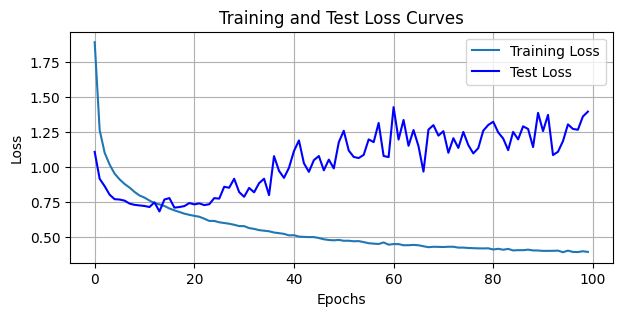

Accuracy is 0.528100
Sensitivity is 0.547007
Specificity is 0.354082
F1-Score Micro is 0.528100
F1-Score Macro is 0.503816
Diagnostic Index is 1.148333
Eta Train is 0.847803
Eta Test is 0.957245
Eta Ratio is 1.129089


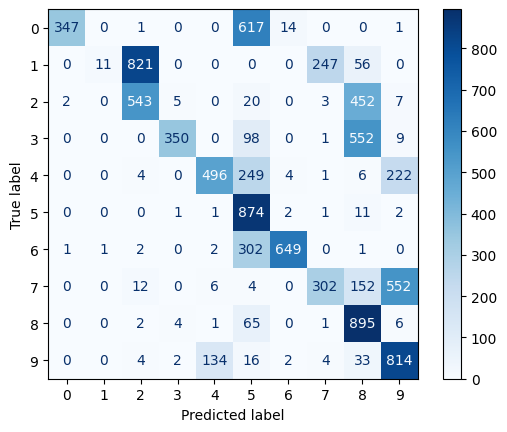

In [ ]:
train_loss_m, test_loss_m = getLosses(history)
plotLosses(train_loss_m, test_loss_m)
model_metrics(y_test_minist_labels, y_pred_minist, train_loss_m, test_loss_m)
cm = confusion_matrix(y_test_minist_labels, y_pred_minist)
disp = ConfusionMatrixDisplay(cm, display_labels = range(0, 10))
disp.plot(cmap = plt.cm.Blues)
plt.show()

## MINIST ADAM

In [ ]:
# MINIST Model
model_m = Sequential([

    # First Convolutional Layer
    Conv1D(16, kernel_size = 1, activation = 'relu', input_shape = (2, 1)),
    MaxPooling1D(pool_size = 1),
    Dropout(0.25),

    # Second Convolutional Layer
    Conv1D(32, kernel_size = 1, activation = 'relu'),
    MaxPooling1D(pool_size = 1),
    Dropout(0.25),

    # Flatten then First Dense Layer
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),

    # Second Dense Layer
    Dense(64, activation = 'relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation = 'softmax')
  ])

# Compile
model_m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit and Predict
history = model_m.fit(
                         x_train_minist_cnn,
                         y_train_minist,
                         batch_size = 128,
                         epochs = 100,
                         verbose = 1,
                         validation_data = (x_test_minist_cnn, y_test_minist)
                         )

predictions = model_m.predict(x_test_minist_cnn)
y_pred_minist = predictions.argmax(axis = 1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.2959 - loss: 3.7180 - val_accuracy: 0.8084 - val_loss: 0.9363
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6237 - loss: 1.0657 - val_accuracy: 0.8640 - val_loss: 0.7658
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7249 - loss: 0.8412 - val_accuracy: 0.8891 - val_loss: 0.7165
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7698 - loss: 0.7621 - val_accuracy: 0.8411 - val_loss: 0.7122
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8054 - loss: 0.6646 - val_accuracy: 0.7831 - val_loss: 0.7218
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8392 - loss: 0.5977 - val_accuracy: 0.6649 - val_loss: 0.8229
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8671 - loss: 0.5265 - val_accuracy: 0.6045 - val_loss: 0.9175
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8881 - loss: 0.4716 - val_accuracy: 0.56

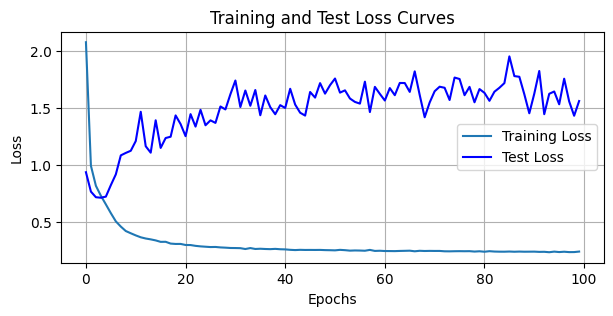

Accuracy is 0.649600
Sensitivity is 0.677384
Specificity is 0.393878
F1-Score Micro is 0.649600
F1-Score Macro is 0.632187
Diagnostic Index is 1.340947
Eta Train is 0.525008
Eta Test is 0.970358
Eta Ratio is 1.848273


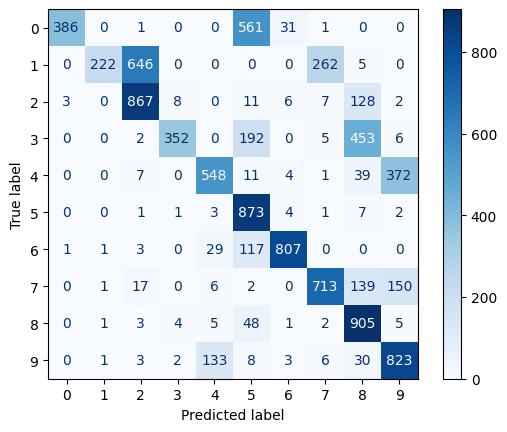

In [ ]:
train_loss_m, test_loss_m = getLosses(history)
plotLosses(train_loss_m, test_loss_m)
model_metrics(y_test_minist_labels, y_pred_minist, train_loss_m, test_loss_m)
cm = confusion_matrix(y_test_minist_labels, y_pred_minist)
disp = ConfusionMatrixDisplay(cm, display_labels = range(0, 10))
disp.plot(cmap = plt.cm.Blues)
plt.show()

## CIFAR SGD

In [ ]:
# CIFAR10 Model
model_c = Sequential([

    # First Convolutional Layer
    Conv1D(16, kernel_size = 1, activation = 'relu', input_shape = (2, 1)),
    MaxPooling1D(pool_size = 1),
    Dropout(0.25),

    # Second Convolutional Layer
    Conv1D(32, kernel_size = 1, activation = 'relu'),
    MaxPooling1D(pool_size = 1),
    Dropout(0.25),

    # Flatten and First Dense Layer
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),

    # Second Dense Layer
    Dense(64, activation = 'relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation = 'softmax')
])

# Compile
model_c.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit and Predict
history = model_c.fit(
                         x_train_cifar_cnn,
                         y_train_cifar,
                         batch_size = 128,
                         epochs = 100,
                         verbose = 1,
                         validation_data = (x_test_cifar_cnn, y_test_cifar)
                         )

predictions = model_m.predict(x_test_cifar_cnn)
y_pred_cifar = predictions.argmax(axis = 1)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.1154 - loss: 2.9193 - val_accuracy: 0.1341 - val_loss: 2.2928
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1307 - loss: 2.2883 - val_accuracy: 0.1390 - val_loss: 2.2779
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1447 - loss: 2.2660 - val_accuracy: 0.1309 - val_loss: 2.2639
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1507 - loss: 2.2488 - val_accuracy: 0.1318 - val_loss: 2.2583
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1552 - loss: 2.2398 - val_accuracy: 0.1360 - val_loss: 2.2554
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1611 - loss: 2.2322 - val_accuracy: 0.1320 - val_loss: 2.2541
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1620 - loss: 2.2241 - val_accuracy: 0.1290 - val_loss: 2.2548
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1629 - loss: 2.2167 - val_ac

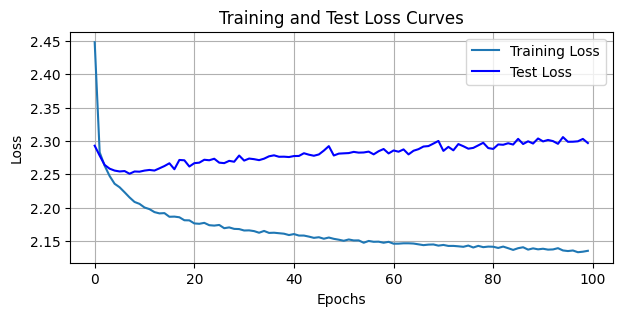

Accuracy is 0.056800
Sensitivity is 0.063111
Specificity is 0.000000
F1-Score Micro is 0.056800
F1-Score Macro is 0.035915
Diagnostic Index is 0.124524
Eta Train is 0.999650
Eta Test is 0.999962
Eta Ratio is 1.000312


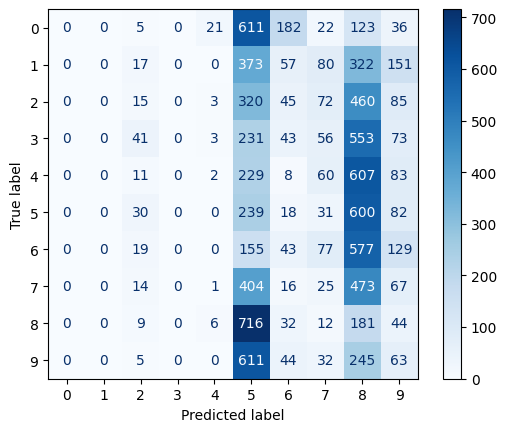

In [ ]:
train_loss_c, test_loss_c = getLosses(history)
plotLosses(train_loss_c, test_loss_c)
model_metrics(y_test_cifar_labels, y_pred_cifar, train_loss_c, test_loss_c)
cm = confusion_matrix(y_test_cifar_labels, y_pred_cifar)
disp = ConfusionMatrixDisplay(cm, display_labels = range(0, 10))
disp.plot(cmap = plt.cm.Blues)
plt.show()

## CIFAR ADAM

In [ ]:
# CIFAR10 Model
model_c = Sequential([

    # First Convolutional Layer
    Conv1D(16, kernel_size = 1, activation = 'relu', input_shape = (2, 1)),
    MaxPooling1D(pool_size = 1),
    Dropout(0.25),

    # Second Convolutional Layer
    Conv1D(32, kernel_size = 1, activation = 'relu'),
    MaxPooling1D(pool_size = 1),
    Dropout(0.25),

    # Flatten and First Dense Layer
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),

    # Second Dense Layer
    Dense(64, activation = 'relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation = 'softmax')
])

# Compile
model_c.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit and Predict
history = model_c.fit(
                         x_train_cifar_cnn,
                         y_train_cifar,
                         batch_size = 128,
                         epochs = 100,
                         verbose = 1,
                         validation_data = (x_test_cifar_cnn, y_test_cifar)
                         )

predictions = model_m.predict(x_test_cifar_cnn)
y_pred_cifar = predictions.argmax(axis = 1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.1093 - loss: 4.2959 - val_accuracy: 0.1016 - val_loss: 2.3016
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1192 - loss: 2.2963 - val_accuracy: 0.0924 - val_loss: 2.2944
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1378 - loss: 2.2604 - val_accuracy: 0.1075 - val_loss: 2.2936
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1493 - loss: 2.2384 - val_accuracy: 0.1151 - val_loss: 2.2805
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1623 - loss: 2.2143 - val_accuracy: 0.1164 - val_loss: 2.2831
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1739 - loss: 2.1991 - val_accuracy: 0.1230 - val_loss: 2.2859
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1807 - loss: 2.1886 - val_accuracy: 0.1295 - val_loss: 2.2813
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1851 - loss: 2.1796 - val_accuracy: 0.11

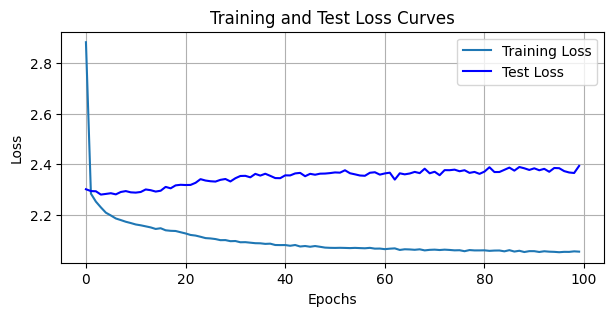

Accuracy is 0.059400
Sensitivity is 0.066000
Specificity is 0.000000
F1-Score Micro is 0.059400
F1-Score Macro is 0.044875
Diagnostic Index is 0.130088
Eta Train is 0.998092
Eta Test is 0.999827
Eta Ratio is 1.001738


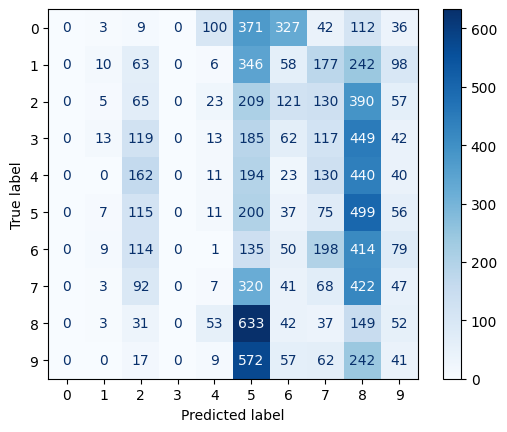

In [ ]:
train_loss_c, test_loss_c = getLosses(history)
plotLosses(train_loss_c, test_loss_c)
model_metrics(y_test_cifar_labels, y_pred_cifar, train_loss_c, test_loss_c)
cm = confusion_matrix(y_test_cifar_labels, y_pred_cifar)
disp = ConfusionMatrixDisplay(cm, display_labels = range(0, 10))
disp.plot(cmap = plt.cm.Blues)
plt.show()

# DNN

## MINIST SGD

In [ ]:
# MINIST Model
model_m = Sequential([

    # Input Layer
    Dense(200, input_shape = (2,), activation = 'relu'),
    Dropout(0.5),

    # First Non-Input Dense Layer
    Dense(100, activation = 'relu'),
    Dropout(0.5),

    # Second Dense Layer
    Dense(50, activation = 'relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation = 'softmax')
  ])

# Compile
model_m.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit and Predict
history = model_m.fit(
                         x_train_minist_tsne,
                         y_train_minist,
                         batch_size = 128,
                         epochs = 100,
                         verbose = 1,
                         validation_data = (x_test_minist_tsne, y_test_minist)
                         )

predictions = model_m.predict(x_test_minist_tsne)
y_pred_minist = predictions.argmax(axis = 1)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3459 - loss: 2.6467 - val_accuracy: 0.7072 - val_loss: 0.9447
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5525 - loss: 1.1734 - val_accuracy: 0.7719 - val_loss: 0.8162
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6210 - loss: 1.0256 - val_accuracy: 0.7846 - val_loss: 0.7807
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6551 - loss: 0.9667 - val_accuracy: 0.8365 - val_loss: 0.7580
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6862 - loss: 0.9115 - val_accuracy: 0.8502 - val_loss: 0.7161
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7063 - loss: 0.8753 - val_accuracy: 0.8528 - val_loss: 0.6880
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7233 - loss: 0.8364 - val_accuracy: 0.8650 - val_loss: 0.6655
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7337 - loss: 0.8221 - val_accu

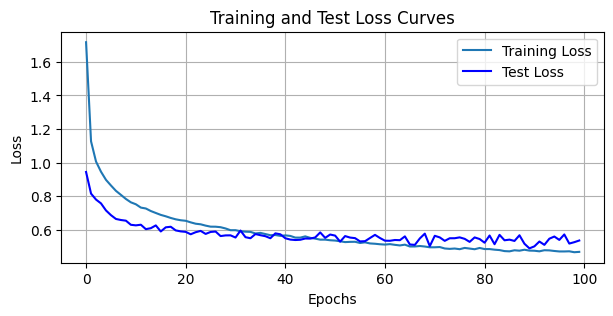

Accuracy is 0.876400
Sensitivity is 0.866741
Specificity is 0.965306
F1-Score Micro is 0.876400
F1-Score Macro is 0.876651
Diagnostic Index is 1.846083
Eta Train is 0.919103
Eta Test is 0.987047
Eta Ratio is 1.073924


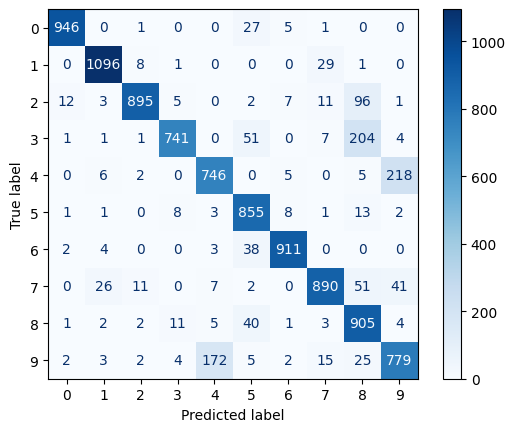

In [ ]:
train_loss_m, test_loss_m = getLosses(history)
plotLosses(train_loss_m, test_loss_m)
model_metrics(y_test_minist_labels, y_pred_minist, train_loss_m, test_loss_m)
cm = confusion_matrix(y_test_minist_labels, y_pred_minist)
disp = ConfusionMatrixDisplay(cm, display_labels = range(0, 10))
disp.plot(cmap = plt.cm.Blues)
plt.show()

## MINIST ADAM

In [ ]:
# MINIST Model
model_m = Sequential([

    # Input Layer
    Dense(200, input_shape = (2, ), activation = 'relu'),
    Dropout(0.5),

    # First Non-Input Dense Layer
    Dense(100, activation = 'relu'),
    Dropout(0.5),

    # Second Dense Layer
    Dense(50, activation = 'relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation = 'softmax')
  ])

# Compile
model_m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit and Predict
history = model_m.fit(
                         x_train_minist_tsne,
                         y_train_minist,
                         batch_size = 128,
                         epochs = 100,
                         verbose = 1,
                         validation_data = (x_test_minist_tsne, y_test_minist)
                         )

predictions = model_m.predict(x_test_minist_tsne)
y_pred_minist = predictions.argmax(axis = 1)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3218 - loss: 3.5492 - val_accuracy: 0.8153 - val_loss: 0.8586
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6421 - loss: 1.0342 - val_accuracy: 0.8784 - val_loss: 0.6990
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7352 - loss: 0.8325 - val_accuracy: 0.8883 - val_loss: 0.6238
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7877 - loss: 0.7121 - val_accuracy: 0.8976 - val_loss: 0.5946
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8171 - loss: 0.6397 - val_accuracy: 0.8981 - val_loss: 0.5769
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8427 - loss: 0.5845 - val_accuracy: 0.8858 - val_loss: 0.5387
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8695 - loss: 0.5184 - val_accuracy: 0.8800 - val_loss: 0.5187
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8890 - loss: 0.4680 - val_acc

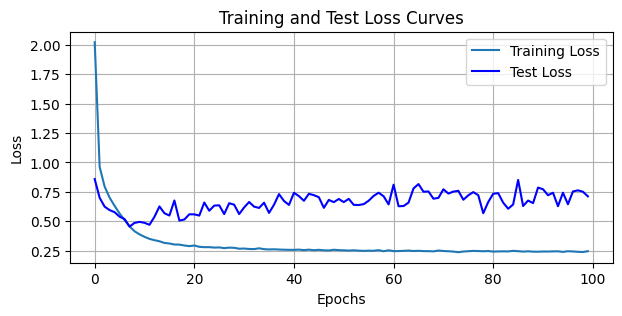

Accuracy is 0.836200
Sensitivity is 0.826275
Specificity is 0.927551
F1-Score Micro is 0.836200
F1-Score Macro is 0.836948
Diagnostic Index is 1.785085
Eta Train is 0.552552
Eta Test is 0.983323
Eta Ratio is 1.779603


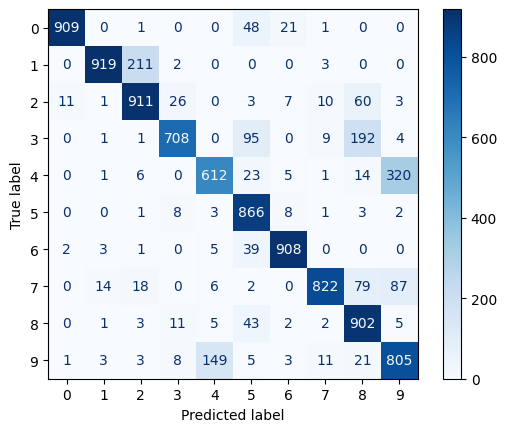

In [ ]:
train_loss_m, test_loss_m = getLosses(history)
plotLosses(train_loss_m, test_loss_m)
model_metrics(y_test_minist_labels, y_pred_minist, train_loss_m, test_loss_m)
cm = confusion_matrix(y_test_minist_labels, y_pred_minist)
disp = ConfusionMatrixDisplay(cm, display_labels = range(0, 10))
disp.plot(cmap = plt.cm.Blues)
plt.show()

## CIFAR SGD

In [ ]:
# CIFAR Model
model_c = Sequential([

    # Input Layer
    Dense(200, input_shape = (2,), activation = 'relu'),
    Dropout(0.5),

    # First Non-Input Dense Layer
    Dense(100, activation = 'relu'),
    Dropout(0.5),

    # Second Dense Layer
    Dense(50, activation = 'relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation = 'softmax')
  ])

# Compile
model_c.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit and Predict
history = model_c.fit(
                         x_train_cifar_tsne,
                         y_train_cifar,
                         batch_size = 128,
                         epochs = 100,
                         verbose = 1,
                         validation_data = (x_test_cifar_tsne, y_test_cifar)
                         )

predictions = model_c.predict(x_test_cifar_tsne)
y_pred_cifar = predictions.argmax(axis = 1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1151 - loss: 3.3149 - val_accuracy: 0.1256 - val_loss: 2.2866
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1414 - loss: 2.2680 - val_accuracy: 0.1077 - val_loss: 2.2826
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1474 - loss: 2.2425 - val_accuracy: 0.1142 - val_loss: 2.2771
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1577 - loss: 2.2244 - val_accuracy: 0.1222 - val_loss: 2.2733
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1681 - loss: 2.2131 - val_accuracy: 0.1195 - val_loss: 2.2806
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1700 - loss: 2.2026 - val_accuracy: 0.1212 - val_loss: 2.2808
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1758 - loss: 2.1973 - val_accuracy: 0.1189 - val_loss: 2.2850
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1764 - loss: 2.1889 - val_accuracy: 0.1107

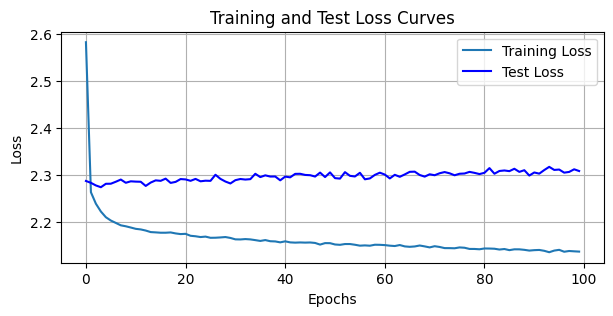

Accuracy is 0.116900
Sensitivity is 0.129444
Specificity is 0.004000
F1-Score Micro is 0.116900
F1-Score Macro is 0.072484
Diagnostic Index is 0.252685
Eta Train is 0.999522
Eta Test is 0.999983
Eta Ratio is 1.000461


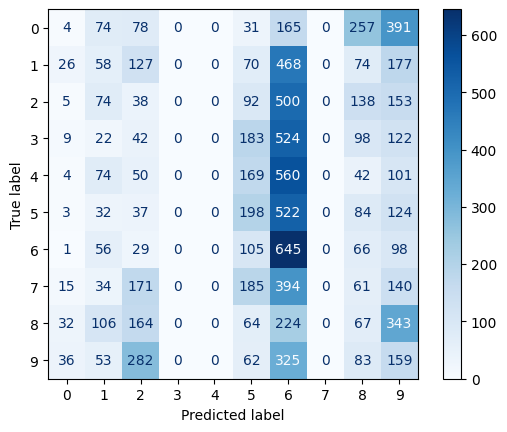

In [ ]:
train_loss_c, test_loss_c = getLosses(history)
plotLosses(train_loss_c, test_loss_c)
model_metrics(y_test_cifar_labels, y_pred_cifar, train_loss_c, test_loss_c)
cm = confusion_matrix(y_test_cifar_labels, y_pred_cifar)
disp = ConfusionMatrixDisplay(cm, display_labels = range(0, 10))
disp.plot(cmap = plt.cm.Blues)
plt.show()

## CIFAR ADAM

In [ ]:
# CIFAR Model
model_c = Sequential([

    # Input Layer
    Dense(200, input_shape = (2, ), activation = 'relu'),
    Dropout(0.5),

    # First Non-Input Dense Layer
    Dense(100, activation = 'relu'),
    Dropout(0.5),

    # Second Dense Layer
    Dense(50, activation = 'relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation = 'softmax')
  ])

# Compile
model_c.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit and Predict
history = model_c.fit(
                         x_train_cifar_tsne,
                         y_train_cifar,
                         batch_size = 128,
                         epochs = 100,
                         verbose = 1,
                         validation_data = (x_test_cifar_tsne, y_test_cifar)
                         )

predictions = model_c.predict(x_test_cifar_tsne)
y_pred_cifar = predictions.argmax(axis = 1)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.1155 - loss: 3.8069 - val_accuracy: 0.0887 - val_loss: 2.3030
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1344 - loss: 2.2814 - val_accuracy: 0.1057 - val_loss: 2.2877
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1562 - loss: 2.2320 - val_accuracy: 0.1106 - val_loss: 2.2814
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1646 - loss: 2.2022 - val_accuracy: 0.1072 - val_loss: 2.2884
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1743 - loss: 2.1886 - val_accuracy: 0.1104 - val_loss: 2.2934
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1895 - loss: 2.1781 - val_accuracy: 0.1231 - val_loss: 2.2808
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1910 - loss: 2.1653 - val_accuracy: 0.1290 - val_loss: 2.2901
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1959 - loss: 2.1591 - val_acc

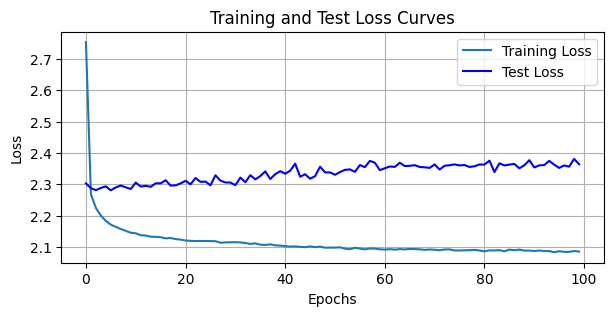

Accuracy is 0.128100
Sensitivity is 0.137000
Specificity is 0.048000
F1-Score Micro is 0.128100
F1-Score Macro is 0.100979
Diagnostic Index is 0.301528
Eta Train is 0.998881
Eta Test is 0.999856
Eta Ratio is 1.000976


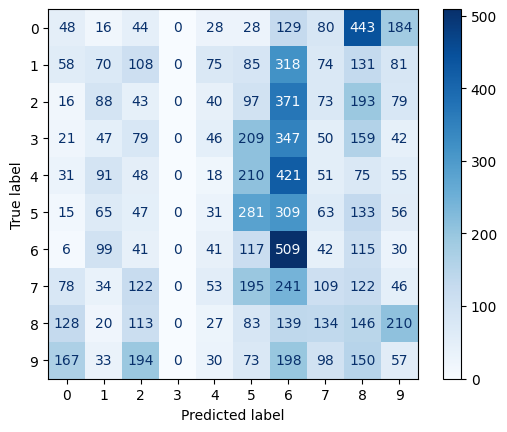

In [ ]:
train_loss_c, test_loss_c = getLosses(history)
plotLosses(train_loss_c, test_loss_c)
model_metrics(y_test_cifar_labels, y_pred_cifar, train_loss_c, test_loss_c)
cm = confusion_matrix(y_test_cifar_labels, y_pred_cifar)
disp = ConfusionMatrixDisplay(cm, display_labels = range(0, 10))
disp.plot(cmap = plt.cm.Blues)
plt.show()